<a href="https://colab.research.google.com/github/paddy3696/NN_from_scratch/blob/main/MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install wandb -q

     |████████████████████████████████| 2.0MB 5.8MB/s 
     |████████████████████████████████| 163kB 37.3MB/s 
     |████████████████████████████████| 133kB 45.6MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb
#wandb.init(project='mnist_classification', entity='paddy3696')

In [ ]:
def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat.T

In [ ]:
class MyNN(object):

    def __init__(self,layer_dims,hidden_layers,init_type='he_normal',learning_rate=0.1,
                 optimization_method = 'SGD',batch_size=64,max_epoch=100,tolarance = 0.00001,
                 keep_proba=1,penality='l2',lamda=0,beta1=0.9,
                 beta2=0.999,seed=None,verbose=0):
        self.layer_dims = layer_dims
        self.hidden_layers = hidden_layers
        self.init_type = init_type
        self.learning_rate = learning_rate
        self.optimization_method = optimization_method
        self.batch_size = batch_size
        self.keep_proba = keep_proba
        self.penality = penality
        self.lamda = lamda
        self.beta1 = beta1
        self.beta2 = beta2
        self.seed = seed
        self.max_epoch = max_epoch
        self.tol = tolarance
        self.verbose = verbose
    @staticmethod
    def weights_init(layer_dims,init_type='he_normal',seed=None):
        
        np.random.seed(seed)
        parameters = {}
        opt_parameters = {}
        L = len(layer_dims)            # number of layers in the network
        if  init_type == 'he_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], 1))  
               
        elif init_type == 'xavier_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], 1))

        return parameters
    
    @staticmethod
    def sigmoid(X,derivative=False):
        if derivative == False:
            out = 1 / (1 + np.exp(-np.array(X)))
        elif derivative == True:
            s = 1 / (1 + np.exp(-np.array(X)))
            out = s*(1-s)
        return out
    @staticmethod
    def ReLU(X,alpha=0,derivative=False):
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*X,X)
        elif derivative == True:
            X_relu = np.ones_like(X,dtype=np.float64)
            X_relu[X < 0] = alpha
            return X_relu
    @staticmethod
    def Tanh(X,derivative=False):
        X = np.array(X)
        if derivative == False:
            return np.tanh(X)
        if derivative == True:
            return 1 - (np.tanh(X))**2
    @staticmethod
    def softmax(X):
        return np.exp(X) / np.sum(np.exp(X),axis=0)
    @staticmethod
    def forward_propagation(X, hidden_layers,parameters,keep_prob=1,seed=None):
    
        if seed != None:
            np.random.seed(seed)
        caches = []
        A = X
        L = len(hidden_layers)
        for l,active_function in enumerate(hidden_layers,start=1):
            A_prev = A 
        
            Z = np.dot(parameters['W' + str(l)],A_prev)+parameters['b' + str(l)]
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    A = MyNN.ReLU(Z,active_function[1])
            else:
                if active_function == "sigmoid":
                    A = MyNN.sigmoid(Z)
                elif active_function == "tanh":
                    A = MyNN.Tanh(Z)
                elif active_function == "softmax":
                    A = MyNN.softmax(Z)
                elif  active_function == "relu":
                    A = MyNN.ReLU(Z)
            
            if keep_prob != 1 and l != L and l != 1:
                D = np.random.rand(A.shape[0],A.shape[1])
                D = (D<keep_prob)
                A = np.multiply(A,D)
                A = A / keep_prob
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)],D), Z)
                caches.append(cache)
            else:
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)]), Z)
                #print(A.shape)
                caches.append(cache)      
        return A, caches

    @staticmethod
    def compute_cost(A, Y, parameters, lamda=0,penality=None):

        m = Y.shape[1]
    
        cost = np.squeeze(-np.sum(np.multiply(np.log(A),Y))/m)
    
        L = len(parameters)//2
    
        if penality == 'l2' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.square(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        elif penality == 'l1' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.abs(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        return cost

    @staticmethod
    def back_propagation(AL, Y, caches, hidden_layers, keep_prob=1, penality=None,lamda=0):

        grads = {}
        L = len(caches) # the number of layers
    
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
    
        # Initializing the backpropagation
        dZL = AL - Y
    
        cache = caches[L-1]
        linear_cache, activation_cache = cache
        AL, W, b = linear_cache
        grads["dW" + str(L)] = np.dot(dZL,AL.T)/m
        grads["db" + str(L)] = np.sum(dZL,axis=1,keepdims=True)/m
        grads["dA" + str(L-1)] = np.dot(W.T,dZL)
    
    
        # Loop from l=L-2 to l=0
        v_dropout = 0
        for l in reversed(range(L-1)):
            cache = caches[l]
            active_function = hidden_layers[l]
        
            linear_cache, Z = cache
            try:
                A_prev, W, b = linear_cache
            except:
                A_prev, W, b, D = linear_cache
                v_dropout = 1
            
            m = A_prev.shape[1]
        
            if keep_prob != 1 and v_dropout == 1:
                dA_prev = np.multiply(grads["dA" + str(l + 1)],D)
                dA_prev = dA_prev/keep_prob
                v_dropout = 0
            else:
                dA_prev = grads["dA" + str(l + 1)]
                v_dropout = 0
            
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    dZ = np.multiply(dA_prev,MyNN.ReLU(Z,active_function[1],derivative=True))

            else:
                if active_function == "sigmoid":
                    dZ = np.multiply(dA_prev,MyNN.sigmoid(Z,derivative=True))
                elif active_function == "relu":
                    dZ = np.multiply(dA_prev,MyNN.ReLU(Z,derivative=True))
                elif active_function == "tanh":
                    dZ = np.multiply(dA_prev,MyNN.Tanh(Z,derivative=True))
            
            grads["dA" + str(l)] = np.dot(W.T,dZ)
        
            if penality == 'l2':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * W)/m)
            elif penality == 'l1':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * np.sign(W+10**-8))/m)
            else:
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)
            
            grads["db" + str(l + 1)] = np.sum(dZ,axis=1,keepdims=True)/m   
        return grads
    
    @staticmethod
    def update_parameters(parameters, grads,learning_rate,iter_no,method = 'SGD',opt_parameters=None,beta1=0.9,beta2=0.999):
    
        L = len(parameters) // 2 # number of layers in the neural network
        if method == 'SGD':
            for l in range(L):
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
            opt_parameters = None
        elif method == 'SGDM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*opt_parameters['vdw'+str(l+1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*opt_parameters['vdb'+str(l+1)]
        elif method == 'RMSP':
            for l in range(L):
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                     (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                           (1-beta2)*np.square(grads["dW" + str(l + 1)])
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(grads["dW" + str(l + 1)]/(np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(grads["db" + str(l + 1)]/(np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        elif method == 'ADAM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                                  (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                                   (1-beta2)*np.square(grads["dW" + str(l + 1)])
            
                learning_rate = learning_rate * np.sqrt((1-beta2**iter_no)/((1-beta1**iter_no)+10**-8))
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdw'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdb'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        
        elif method == 'NADAM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                                  (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                                   (1-beta2)*np.square(grads["dW" + str(l + 1)])
            
                
                learning_rate = learning_rate * np.sqrt((1-beta2**iter_no)/((1-beta1**iter_no)+10**-8))
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*((beta1*opt_parameters['vdw'+str(l+1)])/\
                                                      (np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*((beta1*opt_parameters['vdb'+str(l+1)]+ (1-beta1)*grads["db" + str(l + 1)])/\
                                                      (np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        
        return parameters,opt_parameters
    
    def fit(self,X,y,x_valid,y_valid):

        x_train = X
        y_train = y
        X_valid = X
        Y_valid = y
        y = one_hot(y, 10)
        np.random.seed(self.seed)
        self.grads = {}
        self.costs = []
        M = X.shape[1]
        opt_parameters = {}
        
        if self.verbose == 1:
            print('Initilizing Weights...')
        self.parameters = self.weights_init(self.layer_dims,self.init_type,self.seed)
        self.iter_no = 0
        idx = np.arange(0,M)
        
        if self.optimization_method != 'SGD':
            for l in range(1, len(self.layer_dims)):
                opt_parameters['vdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['vdb' + str(l)] = np.zeros((self.layer_dims[l], 1))
                opt_parameters['sdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['sdb' + str(l)] = np.zeros((self.layer_dims[l], 1)) 
        
        if self.verbose == 1:
            print('Starting Training...')
            
        for epoch_no in range(1,self.max_epoch+1):
            acc_epoch = []
            np.random.shuffle(idx)
            X = X[:,idx]
            y = y[:,idx]
            for i in range(0,M, self.batch_size):
                self.iter_no = self.iter_no + 1
                X_batch = X[:,i:i + self.batch_size]
                y_batch = y[:,i:i + self.batch_size]
                # Forward propagation:
                AL, cache = self.forward_propagation(X_batch,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
                #cost
                cost = self.compute_cost(AL, y_batch, self.parameters,self.lamda,self.penality)
                self.costs.append(cost)
                
                if self.tol != None:
                    try:
                        if abs(cost - self.costs[-2]) < self.tol:
                            return self
                    except:
                        pass
                #back prop
                grads = self.back_propagation(AL, y_batch, cache,self.hidden_layers,self.keep_proba,self.penality,self.lamda)
                
                #update params
                self.parameters,opt_parameters = self.update_parameters(self.parameters,grads,self.learning_rate,
                                                                        self.iter_no-1,self.optimization_method,
                                                                        opt_parameters,self.beta1,self.beta2)
                                
                if self.verbose == 1:
                    if self.iter_no % 1000 == 0:
                        
                        print("Cost after iteration {}: {}".format(self.iter_no, cost))
                        #wandb.log({'Training Error' : cost}
                
                wandb.log({'Training Loss' : cost})
                

            y_pred_train = self.predict(x_train)
            y_pred_valid = self.predict(x_valid)

            train_acc = accuracy_score(y_train, y_pred_train)
            valid_acc = accuracy_score(y_valid, y_pred_valid)

            if self.verbose == 1:
              print('Train Accuracy: %.2f%%' % (train_acc * 100))
              print('Validation Accuracy: %.2f%%' % (valid_acc * 100))
            
            wandb.log({'Training accuracy per epoch' : train_acc})
            wandb.log({'Validation accuracy per epoch' : valid_acc})
            acc_epoch.append(valid_acc)

        acc_best = max(acc_epoch)
        if self.verbose == 1:
          print('Best Validation Accuracy: %.2f%%' % (acc_best * 100))
          
        wandb.log({'accuracy' : valid_acc})
        return self
    def predict(self,X,proba=False):
        
        out, _ = self.forward_propagation(X,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
        if proba == True:
            return out.T
        else:
            return np.argmax(out, axis=0)


4423680/4422102 [==============================] - 0s 0us/step


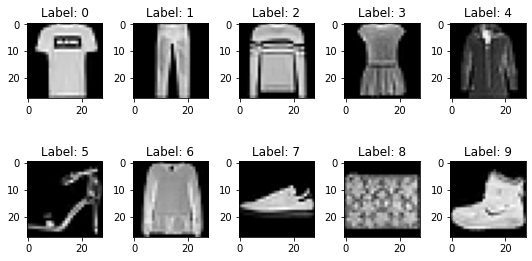

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(class_num):
  ax = axes[i//num_col, i%num_col]
  a = np.argmax(y_train == i)
  ax.imshow(x_train[a], cmap='gray')
  ax.set_title('Label: {}'.format(y_train[a]))
plt.tight_layout()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

x_train = x_train.reshape((len(x_train), 28*28))
x_train = x_train.astype('float32') / 255

x_valid = x_valid.reshape((len(x_valid), 28*28))
x_valid = x_valid.astype('float32') / 255

# Preprocessing test data
x_test = x_test.reshape((len(x_test), 28 * 28))
x_test = x_test.astype('float32') / 225

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'max_epoch': {
            'values': [20, 30]
        },
        'init_type': {
            'values': ['he_normal', 'xavier_uniform']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'hidden_size': {
            'values': [32, 64, 128]
        },
        'n_hidden': {
            'values': [3,4,5]
        },
        'lamda': {
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimization_method': {
            'values': ['SGD','SGDM','RMSP','ADAM','NADAM'] 
        },
        'activation': {
            'values': ['relu','sigmoid','tanh']
        },
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="paddy3696", project="mnist_classification")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 0epp8unf
Sweep URL: https://wandb.ai/paddy3696/mnist_classification/sweeps/0epp8unf


In [ ]:
def train():
  # Default values for hyper-parameters we're going to sweep over
  config_defaults = {
      'max_epoch': 20,
      'n_hidden': 3,
      'hidden_size': 64,
      'batch_size': 64,
      'lamda': 0.0005,
      'init_type': 'he_normal',
      'learning_rate': 1e-3,
      'activation': 'tanh',
      'optimization_method': 'NADAM',
      'seed': 9,
      'verbose':1,
      'penality':'l2'
  }

  # Initialize a new wandb run
  wandb.init(config=config_defaults)

  
    
  # Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config

  X = x_train.T
  X_valid = x_valid.T
  Y_valid = y_valid
  Y = y_train
  #X_test = x_test.T
  n_class= 10

  if config.activation == 'relu':
    config.init_type = 'he_normal'
  else:
    config.init_type = 'xavier_uniform'

  layers = []
  for i in range(config.n_hidden+2):
	  if i == 0:
		  layers.append(X.shape[0])
	  elif i == config.n_hidden+1:
		  layers.append(n_class)
	  else:
		  layers.append(config.hidden_size)
	  i = i+1

  print(layers)

  o_act = 'softmax'
  if config.activation == 'relu':
    config.activation = ('relu',0)
  else:
    config.activation = config.activation

  act = []
  for i in range(config.n_hidden+1):
    if i == config.n_hidden:
      act.append(o_act)
    else:
      act.append(config.activation)
    i = i+1

  print(act)

  
  wandb.run.name = str(config.optimization_method) +'_'+ str(config.activation) + '_bs_' + str(config.batch_size)
  #wandb.run.save()  

  model = MyNN(layer_dims=layers,hidden_layers=act, init_type = config.init_type,
               optimization_method=config.optimization_method,tolarance=None,max_epoch=config.max_epoch,verbose=config.verbose,seed=config.seed,
               penality =config.penality,lamda = config.lamda, learning_rate = config.learning_rate, batch_size = config.batch_size)
  
  model.fit(X,Y,X_valid,Y_valid)

In [ ]:
wandb.agent(sweep_id, train,count=2)

wandb: Agent Starting Run: le1ftbc5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hidden_size: 128
wandb: 	init_type: xavier_uniform
wandb: 	lamda: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	n_hidden: 4
wandb: 	optimization_method: SGDM


wandb: WARNING Config item 'init_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).


[784, 128, 128, 128, 128, 10]
['tanh', 'tanh', 'tanh', 'tanh', 'softmax']
Initilizing Weights...
Starting Training...
Cost after iteration 1000: 11.349772724130712
Cost after iteration 2000: 11.14583159844834
Cost after iteration 3000: 10.828203871234784


wandb: Ctrl + C detected. Stopping sweep.
